In [1]:
import numpy as np
from funcy import flatten
import copy

import jointpmf as jp

import networkx as nx

import itertools

import importlib
import traceback

import pandas as pd

c:\Users\rquax1\Repositories\jointpmf_package\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
numvalues = 3

bn = jp.BayesianNetwork()

In [5]:
pdf0 = jp.JointProbabilityMatrix(1, numvalues, 'uniform')
bn.append_independent_variable(pdf0)

0

In [6]:
cond_pdf = jp.ConditionalProbabilityMatrix()
cond_pdf.generate_random_conditional_pdf(1, 1, numvalues)

bn.append_conditional_variable(cond_pdf, [0])

1

In [7]:
cond_pdf2 = jp.ConditionalProbabilityMatrix()
cond_pdf2.generate_random_conditional_pdf(2, 1, numvalues)

bn.append_conditional_variable(cond_pdf2, [0, 1])

2

In [8]:
bn.numvalues

[3, 3, 3]

## Test marginalization of a single variable

In [11]:
bn_marg = copy.deepcopy(bn)

print(f'{bn_marg.dependency_graph.edges=}')

bn_marg.marginalize(2)  # this variable now no longer depends on other variables

print(f'{bn_marg.dependency_graph.edges=}')

assert isinstance(bn_marg.pdfs[2], jp.JointProbabilityMatrix)
assert bn_marg.dependency_graph.in_degree(2) == 0

bn.dependency_graph.edges=OutEdgeView([(0, 1)])
bn.dependency_graph.edges=OutEdgeView([(0, 1)])


## From a BN to parameters and back

For optimization.

In [8]:
params = bn.matrix2params()
print(params)
params += [s for s in np.random.randn(len(params)) * 0.05]
params = [min(1., max(0., p)) for p in params]
print(params)

[0.33333333 0.5        0.05657495 0.75950447 0.24781656 0.03830149
 0.4452598  0.27440416 0.97459163 0.33749372 0.59195569 0.71546325
 0.57589822 0.36029135 0.29783048 0.55027461 0.75261935 0.84944872
 0.43540586 0.36540065 0.42214353 0.22461729 0.69575084 0.65640417
 0.66416736 0.37280539]
[0.31669465101187755, 0.48767859982685435, 0.04670474414016046, 0.8355355495090964, 0.2577471879930083, 0.01748606690321526, 0.5060068930164429, 0.20402512348855956, 0.9328784711014523, 0.4382557787179081, 0.5849177386616005, 0.7307807489607328, 0.5146325888257988, 0.39707465404755415, 0.3003153774571711, 0.5240089083793006, 0.7159797391173679, 0.8252796758822887, 0.43899730374680146, 0.31765900959415944, 0.4049737334972919, 0.2550281161740762, 0.6682805172307901, 0.6380454034993639, 0.7007721771826869, 0.2703192792946739]


In [9]:
bn2 = copy.deepcopy(bn)
bn2.params2matrix(params)
print(bn2.matrix2params())

assert np.std(np.subtract(params, bn2.matrix2params())) < 0.001 or max(bn2.matrix2params()) > 0.999 or min(bn2.matrix2params()) < 0.001, 'should be almost equal, up to numerical errors'

[0.31669465 0.4876786  0.04670474 0.83553555 0.25774719 0.01748607
 0.50600689 0.20402512 0.93287847 0.43825578 0.58491774 0.73078075
 0.51463259 0.39707465 0.30031538 0.52400891 0.71597974 0.82527968
 0.4389973  0.31765901 0.40497373 0.25502812 0.66828052 0.6380454
 0.70077218 0.27031928]


In [10]:
bn.numvalues[1]

3

In [11]:
assert len(list(bn.statespace([]))) == 1, f'expecting one empty tuple, but got: {list(bn.statespace([]))}'
assert len(list(bn.statespace([1, 2]))) == bn.numvalues[1] * bn.numvalues[2]

## Test computing probabilities (joint, marginal, conditional)

In [12]:
bn.joint_probability([0]*len(bn))

0.01837915676694906

In [13]:
print(bn.joint_probabilities())

np.testing.assert_approx_equal(sum(list(bn.joint_probabilities().values())), 1.0, 3)

{(0, 0, 0): 0.01837915676694906, (0, 0, 1): 0.00016171317793109633, (0, 0, 2): 0.00031744589393554215, (0, 1, 0): 0.14138576537772446, (0, 1, 1): 0.06972863157651273, (0, 1, 2): 0.027730785904804073, (0, 2, 0): 0.043555087203123254, (0, 2, 1): 0.01155625410940651, (0, 2, 2): 0.020518493322946616, (1, 0, 0): 0.02460244204537076, (1, 0, 1): 0.031917621988790064, (1, 0, 2): 0.026085457281598175, (1, 1, 0): 0.007227591143680599, (1, 1, 1): 0.0020179995999934264, (1, 1, 2): 0.0003576583574925772, (1, 2, 0): 0.1049870486183654, (1, 2, 1): 0.04974473646755552, (1, 2, 2): 0.0863927778304868, (2, 0, 0): 0.06265451566142426, (2, 0, 1): 0.019264395897233548, (2, 0, 2): 0.06650102340002709, (2, 1, 0): 0.03530309669851433, (2, 1, 1): 0.010133507467318784, (2, 1, 2): 0.005304400932365826, (2, 2, 0): 0.08911292380743452, (2, 2, 1): 0.016798412925680822, (2, 2, 2): 0.02826105654333413}


In [14]:
# does joint_probability also work with smaller than len(bn) 'values' argument?
print(bn.joint_probability([0]*(len(bn)-1)))
print(bn.joint_probability([0]))

np.testing.assert_approx_equal(bn.joint_probability([0]), 1/3.)
np.testing.assert_approx_equal(bn.joint_probability([1]), 1/3.)
np.testing.assert_approx_equal(bn.joint_probability([2]), 1/3.)

0.018858315838815698
0.3333333333333333


### Conditional probabilities

### Two independent variables

In [15]:
bn3 = jp.BayesianNetwork()

# two independent variables, to test if conditioning makes no difference
bn3.append_independent_variable(jp.JointProbabilityMatrix(1, 4, 'uniform'))
bn3.append_independent_variable(jp.JointProbabilityMatrix(1, 2, 'uniform'))

In [16]:
assert len(bn3.all_upstream_nodes([1])) == 0

In [17]:
2 in bn3.dependency_graph

False

In [18]:
bn3.joint_probabilities()

{(0, 0): 0.125,
 (0, 1): 0.125,
 (1, 0): 0.125,
 (1, 1): 0.125,
 (2, 0): 0.125,
 (2, 1): 0.125,
 (3, 0): 0.125,
 (3, 1): 0.125}

In [19]:
bn3.conditional_probability([1], [1], [0], [0], verbose=2)

debug: flag 1
debug: flag 2
debug: flag 3
debug: flag 4
ancestors=set()
var_ixs_to_sum_over=[]
max_var_ix=1
debug: flag 5: vars_to_compute_prob_for=[1, 0]; joint_state=array([0, 1])
debug: flag 6
debug: loop: flag 7: joint_state=array([0, 1]), vars_to_compute_prob_for=[1, 0]
Pr([0 1]) = 0.125 	vars_to_compute_prob_for=[1, 0]
given_prob=0.25


0.5

In [20]:
assert bn3.conditional_probability([1], [0], [0], [0]) == bn3.conditional_probability([1], [1], [0], [0])

In [21]:
assert bn3.joint_probability([0, -1], variables=[1]) == bn3.joint_probability([0, 1], variables=[1]), '-1 means the highest possible value'

In [22]:
np.testing.assert_allclose([bn3.conditional_probability([0], [v], [1], [0]) for v in range(bn3.numvalues[0])], [1/4.]*4)

In [23]:
assert bn3.conditional_probability([0], [0], [0], [0]) == 1, 'prob(X=x|X=x) should be 1'
# generates a warning because of inconsistent conditioning:
assert bn3.conditional_probability([0], [0], [0], [1]) == 0, 'prob(X!=x|X=x) should be 0'

C:\Users\rquax1\Repositories\jointpmf_package\src\jointpmf\jointpmf.py:6874: UserWarning: inconsistent conditioning: variables overlap=array([0]) but their respective values do not match (at least not for 0)
  warnings.warn(f'inconsistent conditioning: variables {overlap=} but their respective values do not match (at least not for {vix})')


### Three sequentially dependent variables + an independent variable

In [24]:
bn4 = jp.BayesianNetwork()

bn4.append_independent_variable('dirichlet', 2)
bn4.append_conditional_variable('dirichlet', [0], 3)
bn4.append_conditional_variable('dirichlet', [1], 4)
bn4.append_independent_variable('dirichlet', 5)

In [25]:
np.testing.assert_approx_equal(sum(bn4.joint_probabilities().values()), 1.0)

In [26]:
print(bn4.conditional_probability([0], [0], [3], [2], verbose=2), '(should be equal to the last number)')

print(bn4.marginal_probability([0, 3], [0, 2]))
print(bn4.marginal_probability([3], [2]))
print(bn4.marginal_probability([0, 3], [0, 2]) / bn4.marginal_probability([3], [2]), '(should be equal to the first number)')

np.testing.assert_approx_equal(bn4.conditional_probability([0], [0], [3], [2]), bn4.marginal_probability([0, 3], [0, 2]) / bn4.marginal_probability([3], [2]))

debug: flag 1
debug: flag 2
debug: flag 3
debug: flag 4
ancestors=set()
var_ixs_to_sum_over=[]
max_var_ix=3
debug: flag 5: vars_to_compute_prob_for=[0, 3]; joint_state=array([ 0, -1, -1,  2])
debug: flag 6
debug: loop: flag 7: joint_state=array([ 0, -1, -1,  2]), vars_to_compute_prob_for=[0, 3]
Pr([ 0 -1 -1  2]) = 0.01328279920992072 	vars_to_compute_prob_for=[0, 3]
given_prob=0.01709232185917464
0.7771208218145574 (should be equal to the last number)
0.01328279920992072
0.01709232185917464
0.7771208218145574 (should be equal to the first number)


In [27]:
# variable at index 3 is an independent variable so conditioning on it should make no difference
assert np.std([bn4.conditional_probability([0], [0], [3], [v]) for v in range(bn4.numvalues[3])]) < 0.001, 'should all be the same'

In [28]:
bn4.marginal_probability([], [])

1.0

In [29]:
# should sum to 1.0
print([bn4.conditional_probability([1], [v], [2], [0]) for v in range(bn4.numvalues[1])])

np.testing.assert_approx_equal(sum([bn4.conditional_probability([1], [v], [2], [0]) for v in range(bn4.numvalues[1])]), 1.0)

# test this also for conditioning the other way around (a higher variable index on a lower one)

print(bn4.conditional_probability([2], [0], [1], [0], verbose=2))
print(bn4.conditional_probability([2], [1], [1], [0]))
print(bn4.conditional_probability([2], [2], [1], [0]))
print(bn4.conditional_probability([2], [3], [1], [0]))

np.testing.assert_approx_equal(sum([bn4.conditional_probability([2], [v], [1], [0]) for v in range(bn4.numvalues[2])]), 1.0)

[0.6048380080047988, 0.3736342533658248, 0.021527738629376566]
debug: flag 1
debug: flag 2
debug: flag 3
debug: flag 4
ancestors=set()
var_ixs_to_sum_over=[]
max_var_ix=2
debug: flag 5: vars_to_compute_prob_for=[2, 1]; joint_state=array([-1,  0,  0])
debug: flag 6
debug: loop: flag 7: joint_state=array([-1,  0,  0]), vars_to_compute_prob_for=[2, 1]
Pr([-1  0  0]) = 0.10991302464132541 	vars_to_compute_prob_for=[2, 1]
given_prob=0.37838868652269697
0.29047650882852827
0.2243908887018013
0.37794991709973647
0.10718268536993399


In [30]:
# does marginalization work? These pairs should return equal values:

print(f'{bn4.conditional_probability([0], [0], [], [])=}')
print(f'{bn4.joint_probability([0])=}')

np.testing.assert_approx_equal(bn4.conditional_probability([0], [0], [], []), bn4.joint_probability([0]))

print('---')

print(f'{bn4.conditional_probability([1], [1], [], [])=}')
print(f'{bn4.joint_probability([0, 1])+bn4.joint_probability([1, 1])}')

np.testing.assert_approx_equal(bn4.conditional_probability([1], [1], [], []), bn4.joint_probability([0, 1])+bn4.joint_probability([1, 1]))

print('---')

print(f'{bn4.conditional_probability([2], [1], [], [])=}')
print(sum([bn4.joint_probability([v1, v2, 1]) for v1 in range(bn4.numvalues[0]) for v2 in range(bn4.numvalues[1])]))

np.testing.assert_approx_equal(bn4.conditional_probability([2], [1], [], []), sum([bn4.joint_probability([v1, v2, 1]) for v1 in range(bn4.numvalues[0]) for v2 in range(bn4.numvalues[1])]))

bn4.conditional_probability([0], [0], [], [])=0.7771208218145574
bn4.joint_probability([0])=0.7771208218145574
---
bn4.conditional_probability([1], [1], [], [])=0.5068277171958512
0.5068277171958512
---
bn4.conditional_probability([2], [1], [], [])=0.4460631842432756
0.4460631842432756


In [31]:
cond_pmf = bn4.conditional_probabilities([1], [0], verbose=3)

str(cond_pmf)

conditional_probabilities: predecessors_per_var=[[0]]
conditional_probabilities: preds_to_keep=[array([], dtype=int32)]
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x0000029505493F40>.
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x0000029505492230>.


'{(0,): [0.4413124674225004, 0.4299915447106746, 0.128695987866825], (1,): [0.15899008355473107, 0.7747351547272482, 0.06627476171802073]}'

In [32]:
# check one outcome if it matches with the original conditional probability:
np.testing.assert_approx_equal(bn4.conditional_probability([1], [0], [0], [0]), cond_pmf[(0,)].joint_probability([0]))

In [33]:
cond_pmf2 = bn4.conditional_probabilities([1], [2], verbose=3)  # let's condition on something that actually conditions on the variable

str(cond_pmf2)

conditional_probabilities: predecessors_per_var=[[0]]
conditional_probabilities: preds_to_keep=[array([], dtype=int32)]
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054937F0>.
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054A6680>.
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054A6050>.
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054A74F0>.


'{(0,): [0.6048380080047988, 0.3736342533658248, 0.021527738629376566], (1,): [0.1903474140946552, 0.7909842019606965, 0.01866838394464826], (2,): [0.5709008806589198, 0.06617434283138286, 0.3629247765096974], (3,): [0.3332201964885448, 0.5712198077041739, 0.09555999580728147]}'

In [34]:
## checks out as well:

print(bn4.marginal_probability([1], [0]))

print([bn4.conditional_probability([1], [0], [2], [v]) for v in range(bn4.numvalues[2])])

print(sum([bn4.marginal_probability([2], [v]) * bn4.conditional_probability([1], [0], [2], [v]) for v in range(bn4.numvalues[2])]))

print(sum([bn4.marginal_probability([2], [v]) * cond_pmf2[(v,)].joint_probability([0]) for v in range(bn4.numvalues[2])]))

np.testing.assert_almost_equal(sum([bn4.marginal_probability([2], [v]) * bn4.conditional_probability([1], [0], [2], [v]) for v in range(bn4.numvalues[2])]), sum([bn4.marginal_probability([2], [v]) * cond_pmf2[(v,)].joint_probability([0]) for v in range(bn4.numvalues[2])]))
np.testing.assert_almost_equal(bn4.marginal_probability([1], [0]), sum([bn4.marginal_probability([2], [v]) * cond_pmf2[(v,)].joint_probability([0]) for v in range(bn4.numvalues[2])]))

0.37838868652269697
[0.6048380080047988, 0.1903474140946552, 0.5709008806589198, 0.3332201964885448]
0.37838868652269697
0.37838868652269697


In [35]:
cond_pmf3 = bn4.conditional_probabilities([1, 2], [0], verbose=3)  # let's condition on two variables that also condition on one another (2 on 1)

str(cond_pmf3)

conditional_probabilities: predecessors_per_var=[[0], [1]]
conditional_probabilities: preds_to_keep=[array([], dtype=int32), array([1])]
conditional_probabilities: var varix=1 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054BF490>.
conditional_probabilities: var varix=2 is conditional on [1], in the new BN only on [1].
conditional_probabilities: 	extended_given_vars=array([0, 1])
conditional_probabilities: 		cond_dict[(0,)] = <jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054BFFA0>
conditional_probabilities: 		cond_dict[(1,)] = <jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054BF100>
conditional_probabilities: 		cond_dict[(2,)] = <jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054BF610>
conditional_probabilities: 	will append cond_pmf=<jointpmf.jointpmf.ConditionalProbabilityMatrix object at 0x00000295054BEB60>.
conditional_probabilities: var varix=1 is conditi

'{(0,): [0.12819090483939152, 0.0990264967601196, 0.16679401047741418, 0.04730105534557509, 0.057604488808748903, 0.2993393065559996, 0.014063741649957016, 0.058984007695969065, 0.004386252988291582, 0.009336589934949822, 0.10193268940071995, 0.013040455542863654], (1,): [0.04618288440933429, 0.035675926143619745, 0.06009028889919078, 0.017040984102586254, 0.10378860491375197, 0.5393331260424024, 0.025339277474757768, 0.10627414629633615, 0.00225879513769144, 0.004808077419149895, 0.052492426634934496, 0.006715462526244897]}'

In [36]:
cond_pmf4 = bn4.conditional_probabilities([2], [], verbose=3)  # let's see if we can use this function to marginalize (without conditioning)

# should be equal:
print(str(cond_pmf4))
print([bn4.marginal_probability([2], [v]) for v in range(bn4.numvalues[2])])

np.testing.assert_array_almost_equal([cond_pmf4[()].joint_probability([v]) for v in range(cond_pmf4[()].numvalues[0])], [bn4.marginal_probability([2], [v]) for v in range(bn4.numvalues[2])])

conditional_probabilities: predecessors_per_var=[[1]]
conditional_probabilities: preds_to_keep=[array([], dtype=int32)]
conditional_probabilities: var varix=2 is conditional, but not anymore in the new BN. Made into a newpmf=<jointpmf.jointpmf.JointProbabilityMatrix object at 0x00000295054D0910>.
{(): [0.1817230782237041, 0.4460631842432756, 0.25050228077712994, 0.12171145675589035]}
[0.1817230782237041, 0.4460631842432756, 0.25050228077712994, 0.12171145675589035]


### Going from a cond. PMF to parameters and back

In [37]:
## test if a cond. PMF object that contains BayesianNetworks (it was originally developed for JointProbabilityMatrix
## objects) can go from cond. PMF to parameters and back again. The cond. PMF contains two variables of different
## numvalues.

print(next(iter(cond_pmf3.cond_pdf.values())).numvalues)

# from cond PMF (which contains BayesianNetworks) to parameters
cond_params3 = cond_pmf3.matrix2params()

print(cond_params3)

cond_pmf3_copy = copy.deepcopy(cond_pmf3)

print(str(cond_pmf3_copy))

# make this copy first different to see if setting the cond PMF back works:
cond_pmf3_copy.params2matrix(np.random.uniform(0.0, 1.0, len(cond_params3)))

print(str(cond_pmf3_copy))

# from parameters back to cond PMF which contains BayesianNetworks:
cond_pmf3_copy.params2matrix(cond_params3)

print(str(cond_pmf3_copy))

cond_pmf3_dict = cond_pmf3.to_dict()
for k, probs in cond_pmf3_copy.to_dict().items():
    np.testing.assert_array_almost_equal(cond_pmf3_dict[k], probs)

[3, 4]
[0.44131247 0.76964586 0.29047651 0.31625576 0.77906518 0.13396656
 0.80383918 0.19252806 0.03408228 0.07510747 0.88657825 0.15899008
 0.92119622 0.29047651 0.31625576 0.77906518 0.13396656 0.80383918
 0.19252806 0.03408228 0.07510747 0.88657825]
{(0,): [0.12819090483939152, 0.0990264967601196, 0.16679401047741418, 0.04730105534557509, 0.057604488808748903, 0.2993393065559996, 0.014063741649957016, 0.058984007695969065, 0.004386252988291582, 0.009336589934949822, 0.10193268940071995, 0.013040455542863654], (1,): [0.04618288440933429, 0.035675926143619745, 0.06009028889919078, 0.017040984102586254, 0.10378860491375197, 0.5393331260424024, 0.025339277474757768, 0.10627414629633615, 0.00225879513769144, 0.004808077419149895, 0.052492426634934496, 0.006715462526244897]}
{(0,): [0.3563153199373973, 0.04791800672436995, 0.024499816032808763, 0.08843225784131997, 0.08644623803445314, 0.031535700170381556, 0.009011461436532354, 0.009573978163124023, 0.19608970836152767, 0.00332271969925

### Entropy, cond. entropy, mutual information

In [38]:
assert bn4.mutual_information([2], [0]) < bn4.mutual_information([1], [0]), 'DPI dictates'
assert bn4.mutual_information([2], [0]) < bn4.mutual_information([2], [1]), 'DPI dictates'
assert bn4.mutual_information([3], [0]) == 0, f'last variable of bn4 is independent: {bn4.mutual_information([3], [0])=}'

np.testing.assert_almost_equal(bn4.mutual_information([1], [1]), bn4.entropy([1]))

print(bn4.entropy(range(len(bn4))))

totent = bn4.entropy([0])
totent += bn4.conditional_entropy([1], [0])
totent += bn4.conditional_entropy([2], [0, 1])
totent += bn4.conditional_entropy([3], [0, 1, 2])

np.testing.assert_almost_equal(totent, bn4.entropy(range(len(bn4))))

totent2 = bn4.entropy([0])
totent2 += bn4.conditional_entropy([1, 2], [0])
totent2 += bn4.conditional_entropy([3], [0, 1, 2])

np.testing.assert_almost_equal(totent2, bn4.entropy(range(len(bn4))))

# change up the order a bit
totent3 = bn4.entropy([0])
totent3 += bn4.conditional_entropy([1, 3], [0])
try:
    totent3 += bn4.conditional_entropy([2], [0, 3, 1])

    np.testing.assert_almost_equal(totent3, bn4.entropy(range(len(bn4))))
except:
    traceback.print_exc()

C:\Users\rquax1\Repositories\jointpmf_package\src\jointpmf\jointpmf.py:6874: UserWarning: inconsistent conditioning: variables overlap=array([1]) but their respective values do not match (at least not for 1)
  warnings.warn(f'inconsistent conditioning: variables {overlap=} but their respective values do not match (at least not for {vix})')


5.583636413506746


In [39]:
vars = [0, 3, 1]
print(bn4.joint_probability([bn4.numvalues[vix] - 1 for vix in range(max(vars) + 1)], list(sorted(vars))))
print(bn4.joint_probability([bn4.numvalues[vix] - 1 for vix in range(max(vars) + 1)], vars))

0.0033559288743541913
0.0033559288743541913


### Optimization to find an SRV

In [40]:
bn_syn = jp.BayesianNetwork()

# let's start simple: two uniform bits (whose SRV should be an XOR)
bn_syn.append_independent_variable('uniform', 2)
bn_syn.append_independent_variable('uniform', 2)

In [41]:
ix_SRV = 2
ixs_X = [0, 1]

if len(bn_syn) == 2:  # prevent adding more variables if this cell is ran twice or more
    bn_syn.append_conditional_variable('uniform', ixs_X, 2)

params_SRV = bn_syn.pdfs[ix_SRV].matrix2params()

print(f'starting parameters:\t\t{params_SRV}')

obj_init = bn_syn.objective_single_SRV(params_SRV, ix_SRV, ixs_X)

print(f'initial objective value:\t{obj_init}')  # should be 0 for uniform SRV

starting parameters:		[0.5 0.5 0.5 0.5]
initial objective value:	0.0


In [42]:
%%timeit 

# just to see roughly how long an evaluation takes:
obj_init = bn_syn.objective_single_SRV(params_SRV, ix_SRV, ixs_X)

22.7 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.optimization_problems import Ackley, OptimizationProblem
from pySOT.strategy import SRBFStrategy
from pySOT.surrogate import CubicKernel, LinearTail, RBFInterpolant

from poap.controller import SerialController

from collections.abc import Sequence, Iterable

In [44]:
# let's try to define our own optimization problem object, since that seems necessary (?)
class SynergyProblem(OptimizationProblem):
    bn = jp.BayesianNetwork()  # store the BN to be able to reset the SRV with new params (in eval())
    srv_ix = -1
    X_ixs = []
    agn_ixs = []

    def __init__(self, bn_with_srv: jp.BayesianNetwork, srv_ix: int, X_ixs: Sequence[int], agn_ixs: Sequence[int] = []):
        # only get params to obtain the dimensionality of the problem:
        params = bn_with_srv.pdfs[srv_ix].matrix2params()
        dim = len(params)

        self.bn = copy.deepcopy(bn_with_srv)  # this object will be changed during optimization so make a copy
        self.srv_ix = srv_ix
        self.X_ixs = X_ixs
        self.agn_ixs = agn_ixs
        self.dim = dim
        self.min = 0
        self.minimum = np.zeros(dim, dtype=float)
        self.lb = np.zeros(dim, dtype=float)
        self.ub = np.ones(dim, dtype=float)
        self.int_var = np.array([])  # none are integer-valued
        self.cont_var = np.arange(0, dim)
        self.info = str(dim) + "-dimensional SRV optimization for BayesianNetwork: " + str(bn_with_srv)
    
    def eval(self, x) -> float:
        if __debug__:
            assert len(x) == self.dim
        
        fval = self.bn.objective_single_SRV(x, self.srv_ix, self.X_ixs, self.agn_ixs)

        return fval

In [45]:
# obj_func = lambda params: bn_syn.objective_single_SRV(params, ix_SRV, ixs_X)
synprob = SynergyProblem(bn_syn, ix_SRV, ixs_X)  # create a problem object

rbf = RBFInterpolant(dim=synprob.dim, lb=synprob.lb, ub=synprob.ub, kernel=CubicKernel(), tail=LinearTail(synprob.dim))
slhd = SymmetricLatinHypercube(dim=synprob.dim, num_pts=2 * (synprob.dim + 1))

# Create a strategy and a controller
controller = SerialController(objective=synprob.eval)
controller.strategy = SRBFStrategy(max_evals=100, opt_prob=synprob, exp_design=slhd, surrogate=rbf)

In [46]:
optres = controller.run()

In [47]:
print(f'Optimization result:')
print(f'\tParameters:\t{optres.params[0]}')
print(f'\Objective value:\t{optres.value} (theoretical minimum: {-min(bn_syn.entropy(ixs_X), bn_syn.entropy([ix_SRV]))})')
print(f'\Completed:\t\t{optres.is_completed}')

Optimization result:
	Parameters:	[9.98243518e-01 1.40596016e-04 2.43900888e-04 9.99633438e-01]
\Objective value:	-0.9928481192404062 (theoretical minimum: -1.0)
\Completed:		True


#### Use the BN functionality now to do the same

In [48]:
bn_syn2 = jp.BayesianNetwork()

# let's start simple: two uniform bits (whose SRV should be an XOR)
bn_syn2.append_independent_variable('uniform', 2)
bn_syn2.append_independent_variable('uniform', 2)

In [49]:
optres = bn_syn2.append_synergistic_variable([0, 1], 2)

print(f'{len(bn_syn2)=}')

print(f'Optimization result:')
print(f'\tParameters:\t{optres.params[0]}')
print(f'\Objective value:\t{optres.value} (theoretical minimum: {-min(bn_syn.entropy(ixs_X), bn_syn.entropy([ix_SRV]))})')
print(f'\Completed:\t\t{optres.is_completed}')

len(bn_syn2)=3
Optimization result:
	Parameters:	[8.73594727e-05 9.99764360e-01 9.99988927e-01 4.93220946e-04]
\Objective value:	-0.9972970425923224 (theoretical minimum: -1.0)
\Completed:		True


In [56]:
srv2 = bn_syn2.conditional_probabilities([2], [1,0])

print(srv2.to_dict())

{(0, 0): [8.735947265578253e-05, 0.9999126405273442], (0, 1): [0.9999889270866704, 1.1072913329579492e-05], (1, 0): [0.9997643596921445, 0.00023564030785550028], (1, 1): [0.0004932209457539471, 0.999506779054246]}


# Some development snippets

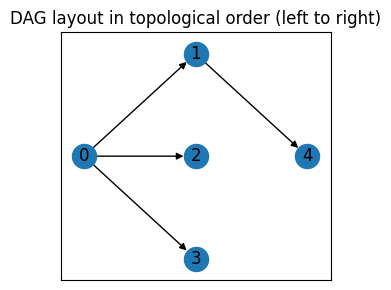

In [17]:
# make a small BN to play with
bn = jp.BayesianNetwork()

bn.infer_random_bn_on_dag(nx.DiGraph([(0, 1), (0, 2), (0, 3), (1, 4)]), 2)

bn.draw_graph((3, 3));

In [18]:
bn_patient = bn.generate_instance_bn()  # make a 'patient', one which has a very specific set of symptoms/diseases

bn_patient.joint_probabilities()  # only one state will have probability 1 here, and the rest 0, meaning that each symptom is set to a specific value

{(0, 0, 0, 0, 0): 0.0,
 (0, 0, 0, 0, 1): 0.0,
 (0, 0, 0, 1, 0): 0.0,
 (0, 0, 0, 1, 1): 0.0,
 (0, 0, 1, 0, 0): 0.0,
 (0, 0, 1, 0, 1): 0.0,
 (0, 0, 1, 1, 0): 0.0,
 (0, 0, 1, 1, 1): 0.0,
 (0, 1, 0, 0, 0): 1.0,
 (0, 1, 0, 0, 1): 0.0,
 (0, 1, 0, 1, 0): 0.0,
 (0, 1, 0, 1, 1): 0.0,
 (0, 1, 1, 0, 0): 0.0,
 (0, 1, 1, 0, 1): 0.0,
 (0, 1, 1, 1, 0): 0.0,
 (0, 1, 1, 1, 1): 0.0,
 (1, 0, 0, 0, 0): 0.0,
 (1, 0, 0, 0, 1): 0.0,
 (1, 0, 0, 1, 0): 0.0,
 (1, 0, 0, 1, 1): 0.0,
 (1, 0, 1, 0, 0): 0.0,
 (1, 0, 1, 0, 1): 0.0,
 (1, 0, 1, 1, 0): 0.0,
 (1, 0, 1, 1, 1): 0.0,
 (1, 1, 0, 0, 0): 0.0,
 (1, 1, 0, 0, 1): 0.0,
 (1, 1, 0, 1, 0): 0.0,
 (1, 1, 0, 1, 1): 0.0,
 (1, 1, 1, 0, 0): 0.0,
 (1, 1, 1, 0, 1): 0.0,
 (1, 1, 1, 1, 0): 0.0,
 (1, 1, 1, 1, 1): 0.0}

In [19]:
varix = 1

symptom_patient = bn_patient.marginal_pmf([varix])

symptom_patient.joint_probabilities()

{(0,): 0.0, (1,): 1.0}

In [20]:
sample = symptom_patient.generate_sample()[0]

bn_patient_pinned = copy.deepcopy(bn_patient)  # for intervention
bn_patient_pinned.pin(varix, shift=1)  # note: shift=1 means that if the current symptom is on (1) then it will be set to off (0) or vice versa (for binary symptoms)

symptom_patient_pinned = bn_patient_pinned.marginal_pmf([varix])

symptom_patient_pinned.joint_probabilities()  # you should see that the probability mass has shifted from 1 to 0 or vice versa, compared to the previous cell

{(0,): 1.0, (1,): 0.0}

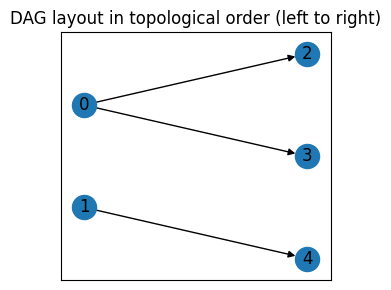

In [23]:
bn_patient_pinned.draw_graph();  # you should see here that the intervened variable (`varix`) no longer has incoming edges; it became an additional root node